In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from mlxtend.frequent_patterns import apriori, association_rules

In [5]:
import networkx as nx

In [6]:
pd.set_option('display.max_columns', 70)

In [7]:
df = pd.read_csv('./result/online-retail-clean.csv')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   main_idx     397884 non-null  int64  
 1   InvoiceNo    397884 non-null  int64  
 2   StockCode    397884 non-null  object 
 3   Description  397884 non-null  object 
 4   Quantity     397884 non-null  int64  
 5   InvoiceDate  397884 non-null  object 
 6   UnitPrice    397884 non-null  float64
 7   CustomerID   397884 non-null  float64
 8   Country      397884 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 27.3+ MB
None


,main_idx,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
# Filter the data into last 3-months
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['date'] = pd.DatetimeIndex(df['InvoiceDate']).date
df['date'] = pd.to_datetime(df['date'])

# Time splitting
n_days = 90
max_date = df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

df = df[df['InvoiceDate'] > cutoff].reset_index(drop=True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161526 entries, 0 to 161525
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   main_idx     161526 non-null  int64         
 1   InvoiceNo    161526 non-null  int64         
 2   StockCode    161526 non-null  object        
 3   Description  161526 non-null  object        
 4   Quantity     161526 non-null  int64         
 5   InvoiceDate  161526 non-null  datetime64[ns]
 6   UnitPrice    161526 non-null  float64       
 7   CustomerID   161526 non-null  float64       
 8   Country      161526 non-null  object        
 9   date         161526 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 12.3+ MB
None


,main_idx,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
0,236358,566225,22384,LUNCH BAG PINK POLKADOT,6,2011-09-11 10:35:00,1.65,16899.0,United Kingdom,2011-09-11
1,236359,566225,20725,LUNCH BAG RED RETROSPOT,6,2011-09-11 10:35:00,1.65,16899.0,United Kingdom,2011-09-11
2,236360,566225,23169,CLASSIC GLASS COOKIE JAR,3,2011-09-11 10:35:00,4.15,16899.0,United Kingdom,2011-09-11
3,236361,566225,84029E,RED WOOLLY HOTTIE WHITE HEART.,3,2011-09-11 10:35:00,4.25,16899.0,United Kingdom,2011-09-11
4,236362,566225,21479,WHITE SKULL HOT WATER BOTTLE,3,2011-09-11 10:35:00,4.25,16899.0,United Kingdom,2011-09-11


In [9]:
top_products = df.groupby('Description')\
                .agg({'InvoiceNo': 'count'})\
                .reset_index()\
                .rename(columns={'InvoiceNo': 'count'})\
                .sort_values(by='count', ascending=False)

top_products = top_products.head(20)['Description'].values

In [10]:
# # Sampling data
# import random

# sample_size = 1000
# idx_data = []
# boundary = []
# for i in range(1, 4):
#     upper = max_date - pd.to_timedelta((i - 1)*30, unit='d')
#     lower = max_date - pd.to_timedelta(i * 30, unit='d')
#     boundary.append((lower, upper))
#     data = list(df[(df['InvoiceDate'] <= upper) & (df['InvoiceDate'] > lower)].index)
#     random_sample = random.sample(data, sample_size)
#     idx_data = idx_data + random_sample

# print(len(idx_data))

In [11]:
# sample_data = df.iloc[idx_data]
# sample_data.head()

In [12]:
basket = df.groupby('InvoiceNo').agg({'Description': set, 'InvoiceDate': 'first'}).reset_index()
basket

,InvoiceNo,Description,InvoiceDate
0,566225,"{LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",2011-09-11 10:35:00
1,566226,"{FOLDING UMBRELLA RED/WHITE POLKADOT, FOLDING ...",2011-09-11 10:39:00
2,566227,"{BLUE HAPPY BIRTHDAY BUNTING, JUMBO BAG PINK P...",2011-09-11 10:42:00
3,566228,"{HAND WARMER SCOTTY DOG DESIGN, HAND WARMER RE...",2011-09-11 10:52:00
4,566229,"{POSTE FRANCE CUSHION COVER, LAVENDER TOILETTE...",2011-09-11 10:53:00
...,...,...,...
6621,581583,"{6 CHOCOLATE LOVE HEART T-LIGHTS, LUNCH BAG RE...",2011-12-09 12:23:00
6622,581584,"{6 CHOCOLATE LOVE HEART T-LIGHTS, RED FLOCK LO...",2011-12-09 12:25:00
6623,581585,"{MULTI COLOUR SILVER T-LIGHT HOLDER, GREY HEAR...",2011-12-09 12:31:00
6624,581586,"{RED RETROSPOT ROUND CAKE TINS, LARGE CAKE STA...",2011-12-09 12:49:00


In [13]:
# # Sampling data
# import random

# sample_size = 1000
# idx_data = []
# boundary = []
# for i in range(1, 4):
#     upper = max_date - pd.to_timedelta((i - 1)*30, unit='d')
#     lower = max_date - pd.to_timedelta(i * 30, unit='d')
#     boundary.append((lower, upper))
#     data = list(basket[(basket['InvoiceDate'] <= upper) & (basket['InvoiceDate'] > lower)].index)
#     random_sample = random.sample(data, sample_size)
#     idx_data = idx_data + random_sample

# print(len(idx_data))

In [14]:
# sample_basket = basket.iloc[idx_data]
# sample_basket

In [15]:
basket_encoded = basket['Description'].str.join('|').str.get_dummies('|')
basket_encoded                                                      

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,...,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP WEDDING DAY,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW GIANT GARDEN THERMOMETER,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6623,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
6624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# basket_encoded = sample_basket['Description'].str.join('|').str.get_dummies('|')
# basket_encoded                                                      

In [17]:
# Convert the DataFrame to use boolean types
basket_encoded_bool = basket_encoded.astype(bool)

# Apply Apriori algorithm
frequent_itemsets = apriori(basket_encoded_bool, 
                            min_support=0.01, 
                            use_colnames=True)

# Display frequent itemsets
frequent_itemsets

,support,itemsets
0,0.015545,( 50'S CHRISTMAS GIFT BAG LARGE)
1,0.011168,( DOLLY GIRL BEAKER)
2,0.010263,( I LOVE LONDON MINI BACKPACK)
3,0.012225,( RED SPOT GIFT BAG LARGE)
4,0.013734,(10 COLOUR SPACEBOY PEN)
...,...,...
1402,0.012074,"(HOT WATER BOTTLE KEEP CALM, HOT WATER BOTTLE ..."
1403,0.010414,"(ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK..."
1404,0.011621,"(HAND WARMER OWL DESIGN, HAND WARMER SCOTTY DO..."
1405,0.010414,"(HAND WARMER OWL DESIGN, HAND WARMER UNION JAC..."


In [18]:
# Generate association rules with lower lift threshold

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(12 PENCIL SMALL TUBE WOODLAND),(SET 12 COLOUR PENCILS SPACEBOY ),0.025506,0.034863,0.011168,0.437870,12.559850,0.010279,1.716929,0.944470
1,(SET 12 COLOUR PENCILS SPACEBOY ),(12 PENCIL SMALL TUBE WOODLAND),0.034863,0.025506,0.011168,0.320346,12.559850,0.010279,1.433810,0.953627
2,(WOOD 2 DRAWER CABINET WHITE FINISH),(3 DRAWER ANTIQUE WHITE WOOD CABINET),0.028977,0.025506,0.014941,0.515625,20.216161,0.014202,2.011859,0.978900
3,(3 DRAWER ANTIQUE WHITE WOOD CABINET),(WOOD 2 DRAWER CABINET WHITE FINISH),0.025506,0.028977,0.014941,0.585799,20.216161,0.014202,2.344328,0.975413
4,(6 GIFT TAGS VINTAGE CHRISTMAS ),(6 GIFT TAGS 50'S CHRISTMAS ),0.034863,0.036221,0.016903,0.484848,13.385859,0.015640,1.870865,0.958718
...,...,...,...,...,...,...,...,...,...,...
1781,"(SET OF 3 WOODEN HEART DECORATIONS, SET OF 3 W...","(SET OF 3 WOODEN STOCKING DECORATION, SET OF 3...",0.019771,0.025204,0.014187,0.717557,28.470266,0.013688,3.451306,0.984337
1782,(SET OF 3 WOODEN TREE DECORATIONS),"(SET OF 3 WOODEN STOCKING DECORATION, SET OF 3...",0.033203,0.015998,0.014187,0.427273,26.708576,0.013655,1.718099,0.995616
1783,(SET OF 3 WOODEN STOCKING DECORATION),"(SET OF 3 WOODEN SLEIGH DECORATIONS, SET OF 3 ...",0.035919,0.016149,0.014187,0.394958,24.457865,0.013606,1.626088,0.994847
1784,(SET OF 3 WOODEN HEART DECORATIONS),"(SET OF 3 WOODEN SLEIGH DECORATIONS, SET OF 3 ...",0.042711,0.017507,0.014187,0.332155,18.972950,0.013439,1.471141,0.989558


In [19]:
# Display association rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

,antecedents,consequents,support,confidence,lift
0,(12 PENCIL SMALL TUBE WOODLAND),(SET 12 COLOUR PENCILS SPACEBOY ),0.011168,0.437870,12.559850
1,(SET 12 COLOUR PENCILS SPACEBOY ),(12 PENCIL SMALL TUBE WOODLAND),0.011168,0.320346,12.559850
2,(WOOD 2 DRAWER CABINET WHITE FINISH),(3 DRAWER ANTIQUE WHITE WOOD CABINET),0.014941,0.515625,20.216161
3,(3 DRAWER ANTIQUE WHITE WOOD CABINET),(WOOD 2 DRAWER CABINET WHITE FINISH),0.014941,0.585799,20.216161
4,(6 GIFT TAGS VINTAGE CHRISTMAS ),(6 GIFT TAGS 50'S CHRISTMAS ),0.016903,0.484848,13.385859
5,(6 GIFT TAGS 50'S CHRISTMAS ),(6 GIFT TAGS VINTAGE CHRISTMAS ),0.016903,0.466667,13.385859
6,(BOX OF 6 MINI 50'S CRACKERS),(6 GIFT TAGS 50'S CHRISTMAS ),0.010564,0.214067,5.910041
7,(6 GIFT TAGS 50'S CHRISTMAS ),(BOX OF 6 MINI 50'S CRACKERS),0.010564,0.291667,5.910041
8,(PAPER CHAIN KIT 50'S CHRISTMAS ),(6 GIFT TAGS 50'S CHRISTMAS ),0.014187,0.122237,3.374751
9,(6 GIFT TAGS 50'S CHRISTMAS ),(PAPER CHAIN KIT 50'S CHRISTMAS ),0.014187,0.391667,3.374751


In [20]:
rules['filter_1'] = rules['antecedents'].apply(lambda x: 1 if len(x) < 2 else 0)
rules['filter_2'] = rules['consequents'].apply(lambda x: 1 if len(x) < 2 else 0)

final = rules[(rules['filter_1'] == 1) & (rules['filter_2'] == 1)]\
        .drop(['filter_1', 'filter_2'], axis=1).copy()

In [21]:
final['antecedents'] = final.loc[:,'antecedents'].apply(lambda x: next(iter(x)))
final['consequents'] = final.loc[:,'consequents'].apply(lambda x: next(iter(x)))
# final = final[final['confidence'] > 0.5].reset_index(drop=True)
# final.to_csv('./result/association-analysis.csv', index_label='idx_assc')
final.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,12 PENCIL SMALL TUBE WOODLAND,SET 12 COLOUR PENCILS SPACEBOY,0.025506,0.034863,0.011168,0.437870,12.559850,0.010279,1.716929,0.944470
1,SET 12 COLOUR PENCILS SPACEBOY,12 PENCIL SMALL TUBE WOODLAND,0.034863,0.025506,0.011168,0.320346,12.559850,0.010279,1.433810,0.953627
2,WOOD 2 DRAWER CABINET WHITE FINISH,3 DRAWER ANTIQUE WHITE WOOD CABINET,0.028977,0.025506,0.014941,0.515625,20.216161,0.014202,2.011859,0.978900
3,3 DRAWER ANTIQUE WHITE WOOD CABINET,WOOD 2 DRAWER CABINET WHITE FINISH,0.025506,0.028977,0.014941,0.585799,20.216161,0.014202,2.344328,0.975413
4,6 GIFT TAGS VINTAGE CHRISTMAS,6 GIFT TAGS 50'S CHRISTMAS,0.034863,0.036221,0.016903,0.484848,13.385859,0.015640,1.870865,0.958718


In [22]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 0 to 1079
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         1080 non-null   object 
 1   consequents         1080 non-null   object 
 2   antecedent support  1080 non-null   float64
 3   consequent support  1080 non-null   float64
 4   support             1080 non-null   float64
 5   confidence          1080 non-null   float64
 6   lift                1080 non-null   float64
 7   leverage            1080 non-null   float64
 8   conviction          1080 non-null   float64
 9   zhangs_metric       1080 non-null   float64
dtypes: float64(8), object(2)
memory usage: 92.8+ KB


In [23]:
final[final['antecedents'] == "LOVE HOT WATER BOTTLE"]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
148,LOVE HOT WATER BOTTLE,CHOCOLATE HOT WATER BOTTLE,0.062481,0.066103,0.016903,0.270531,4.092560,0.012773,1.280243,0.806015
270,LOVE HOT WATER BOTTLE,GREY HEART HOT WATER BOTTLE,0.062481,0.042409,0.013583,0.217391,5.126102,0.010933,1.223589,0.858564
314,LOVE HOT WATER BOTTLE,HAND WARMER OWL DESIGN,0.062481,0.068820,0.011923,0.190821,2.772767,0.007623,1.150772,0.681959
332,LOVE HOT WATER BOTTLE,HAND WARMER RED LOVE HEART,0.062481,0.054331,0.011923,0.190821,3.512171,0.008528,1.168677,0.762946
352,LOVE HOT WATER BOTTLE,HAND WARMER SCOTTY DOG DESIGN,0.062481,0.056444,0.010414,0.166667,2.952763,0.006887,1.132267,0.705409
390,LOVE HOT WATER BOTTLE,HOT WATER BOTTLE I AM SO POORLY,0.062481,0.049502,0.014639,0.234300,4.733136,0.011546,1.241344,0.841288
406,LOVE HOT WATER BOTTLE,HOT WATER BOTTLE KEEP CALM,0.062481,0.099457,0.030033,0.480676,4.833022,0.023819,1.734069,0.845946
426,LOVE HOT WATER BOTTLE,HOT WATER BOTTLE TEA AND SYMPATHY,0.062481,0.063538,0.018110,0.289855,4.561947,0.014141,1.318692,0.832832
650,LOVE HOT WATER BOTTLE,PAPER CHAIN KIT 50'S CHRISTMAS,0.062481,0.116058,0.014488,0.231884,1.998002,0.007237,1.150792,0.532789
652,LOVE HOT WATER BOTTLE,RETROSPOT HEART HOT WATER BOTTLE,0.062481,0.042861,0.014488,0.231884,5.410084,0.011810,1.246086,0.869486


In [24]:
final = final.set_index('antecedents').loc[top_products].reset_index()
final = final[final['confidence'] > 0.2]

In [25]:
# print(len(example.consequents.unique()))

# print(len(example.antecedents.unique()))

In [26]:
# print(len(example[example['confidence'] > 0.2].consequents.unique()))

# print(len(example[example['confidence'] > 0.2].antecedents.unique()))

In [27]:
def changeDigit(x):
    if len(x) == 1:
        return "00" + x
    elif len(x) == 2:
        return "0" + x
    else:
        return x

In [28]:
# Generate connection (format: (antecedents)(consequents))

# Generate unique number for antecedents
temp_ant = final\
            .groupby('antecedents')\
            .first()\
            .reset_index()[['antecedents']]\
            .sort_values(by='antecedents')
temp_ant = temp_ant.reset_index(names='id_antecedents')
temp_ant['id_antecedents'] = temp_ant['id_antecedents'].astype(str).apply(changeDigit)
print(temp_ant.head())

# Generate unique number for consequents
temp_cons = final\
             .groupby('consequents')\
             .first()\
             .reset_index()[['consequents']]\
             .sort_values(by='consequents')
temp_cons = temp_cons.reset_index(names='id_consequents')
temp_cons['id_consequents'] = temp_cons['id_consequents'].astype(str).apply(changeDigit)
print(temp_cons.head())

final = final\
        .merge(temp_ant, on='antecedents')\
        .merge(temp_cons, on='consequents')

final['connection'] = final['id_antecedents'] + final['id_consequents']
final = final.drop(['id_antecedents', 'id_consequents'], axis=1)
print(final.info())
final.head()

  id_antecedents                        antecedents
0            000      BAKING SET 9 PIECE RETROSPOT 
1            001         CHOCOLATE HOT WATER BOTTLE
2            002  GARDENERS KNEELING PAD KEEP CALM 
3            003             HAND WARMER OWL DESIGN
4            004         HOT WATER BOTTLE KEEP CALM
  id_consequents                         consequents
0            000     60 CAKE CASES VINTAGE CHRISTMAS
1            001          BAKING SET SPACEBOY DESIGN
2            002      BOX OF 6 MINI VINTAGE CRACKERS
3            003          CHOCOLATE HOT WATER BOTTLE
4            004  GARDENERS KNEELING PAD CUP OF TEA 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         92 non-null     object 
 1   consequents         92 non-null     object 
 2   antecedent support  92 non-null     float64
 3   consequent suppor

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,connection
0,PAPER CHAIN KIT 50'S CHRISTMAS,JUMBO BAG 50'S CHRISTMAS,0.116058,0.074404,0.024902,0.214564,2.883780,0.016267,1.178449,0.739000,010016
1,JUMBO BAG RED RETROSPOT,JUMBO BAG 50'S CHRISTMAS,0.082554,0.074404,0.019771,0.239488,3.218759,0.013628,1.217070,0.751348,007016
2,JUMBO BAG VINTAGE DOILY,JUMBO BAG 50'S CHRISTMAS,0.070782,0.074404,0.020374,0.287846,3.868703,0.015108,1.299714,0.797999,008016
3,PAPER CHAIN KIT 50'S CHRISTMAS,PAPER CHAIN KIT VINTAGE CHRISTMAS,0.116058,0.081497,0.054181,0.466840,5.728300,0.044722,1.722753,0.933803,010033
4,HOT WATER BOTTLE KEEP CALM,CHOCOLATE HOT WATER BOTTLE,0.099457,0.066103,0.034561,0.347496,5.256872,0.027986,1.431251,0.899205,004003


In [29]:
len(final['connection'].unique())

92

In [30]:
ant = final[['connection', 'antecedents']].copy()
ant['is_antecedents'] = np.ones(ant.shape[0], dtype='int')
ant = ant.values
cons = final[['connection', 'consequents']].copy()
cons['is_antecedents'] = np.zeros(cons.shape[0], dtype='int')
cons = cons.values

# Bridge file
union_node = pd.DataFrame(np.concatenate([ant, cons]), columns=['connection', 'node_name', 'is_antecedents'])

In [31]:
print(len(union_node['node_name'].unique()))

51


In [32]:
# item = np.sort(final['antecedents'].unique())
# print(len(item))
# # item

In [33]:
# # Converting dot_product
# def unique_dot_product(item):
#     dot_products = {frozenset({x, y}) for x in item for y in item}
#     result = []
#     for e in list(dot_products):
#         temp = []
#         for i in iter(e):
#             temp.append(i)
#         result.append(tuple(temp))
#     return result

# dot_product = unique_dot_product(item)

In [34]:
# def fun_connection(inp):
#     result = None
#     try:
#         result = list(dot_product).index(inp)
#     except ValueError:
#         try:
#             inp = (inp[-1], inp[0])
#             result = list(dot_product).index(inp)
#         except ValueError:
#             result = None
#     return result

In [35]:
# final['ant-cons'] = list(zip(final['antecedents'], final['consequents']))

In [36]:
# final['connection'] = final['ant-cons'].apply(fun_connection)
# final = final.drop(['ant-cons'], axis=1)
# final.info()

In [37]:
# final = final.dropna(subset='connection')
# final.info()

In [38]:
# len(final['antecedents'].unique())

In [39]:
# # Generate unique random numbers for its positions in X and Y diagram

# import random

# # Define the range and number of unique float numbers
# start = 1
# end = 10
# num_numbers = len(item) # Change this to the desired number of unique float numbers

# # Generate unique float numbers
# unique_floats = random.sample([random.uniform(start, end) for _ in range(10000)], num_numbers)

# print(len(unique_floats))

In [40]:
# import random
# # Generate node positions in X and Y diagram (in grid)

# num_nodes = len(union_node['node_name'].unique())
# num_y = 12
# num_x = num_nodes // num_y
# print('Number of x', num_x)
# print('Number of y', num_y)

# y = 1
# coor = []
# while y <= num_y:
#     for x in range(1, num_x + 1):
#         coor.append([x, y])
#     y += 1

# if len(coor) < num_nodes:
#     diff = num_nodes - len(coor)
#     while diff != 0:
#         for x in range(1, num_x + 1):
#             coor.append([x, y])
#             diff = num_nodes - len(coor)
#             if diff == 0:
#                 break
#         y += 1

# random.shuffle(coor)
# len(coor)

In [41]:
# import math
# import random

# # Generate node positions in X and Y diagram (in spiral)

# def generate_spiral_coordinate(radius_range=(0, 10), 
#                                theta_range=(0, 2*math.pi)):
#     radius = random.uniform(*radius_range)
#     theta = random.uniform(*theta_range)
#     x = radius * math.cos(theta)
#     y = radius * math.sin(theta)
#     return [x, y]


# num_points = len(union_node['node_name'].unique())
# coor = [generate_spiral_coordinate() for _ in range(num_points)]


In [45]:
# Generate node positions in X and Y diagram (in circle-grid)

def generate_grid_circle_points(num_points_per_circle, num_circles, radius_list):
    points = []
    for i, radius in enumerate(radius_list):
        for j in range(num_points_per_circle):
            angle = j * (2 * np.pi / num_points_per_circle)
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            points.append([x, y])
    return points

num_points = len(union_node['node_name'].unique())
num_circles = 10  # Number of circles
num_points_per_circle = num_points // num_circles + 1  # Number of points per circle
radius_list = np.linspace(1.0, 5.0, num_circles)  # List of radii

coor = generate_grid_circle_points(num_points_per_circle, num_circles, radius_list)

In [46]:
positions = pd.DataFrame()
positions['node_name'] = union_node['node_name'].unique()
positions[['X', 'Y']] = coor[:51]
print(positions.shape)

(51, 3)


In [47]:
positions.head()

,node_name,X,Y
0,PAPER CHAIN KIT 50'S CHRISTMAS,1.0,0.000000e+00
1,JUMBO BAG RED RETROSPOT,0.5,8.660254e-01
2,JUMBO BAG VINTAGE DOILY,-0.5,8.660254e-01
3,HOT WATER BOTTLE KEEP CALM,-1.0,1.224647e-16
4,LOVE HOT WATER BOTTLE,-0.5,-8.660254e-01


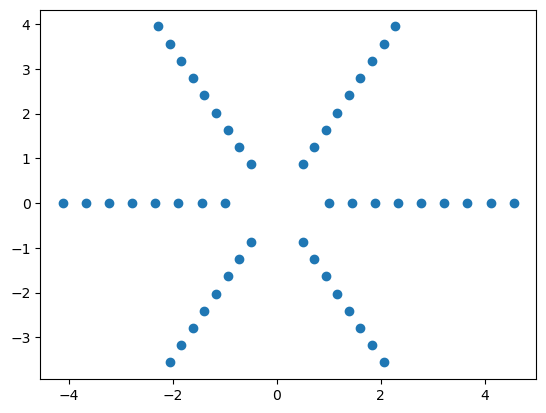

In [49]:
plt.scatter(positions['X'], positions['Y'])
plt.show()

In [62]:
positions.to_csv('./result/CoorFile.csv', index_label='Node_ID')
final.to_csv('./result/association-analysis.csv', index=False)
union_node.to_csv('./result/nodeFile.csv', index=False)

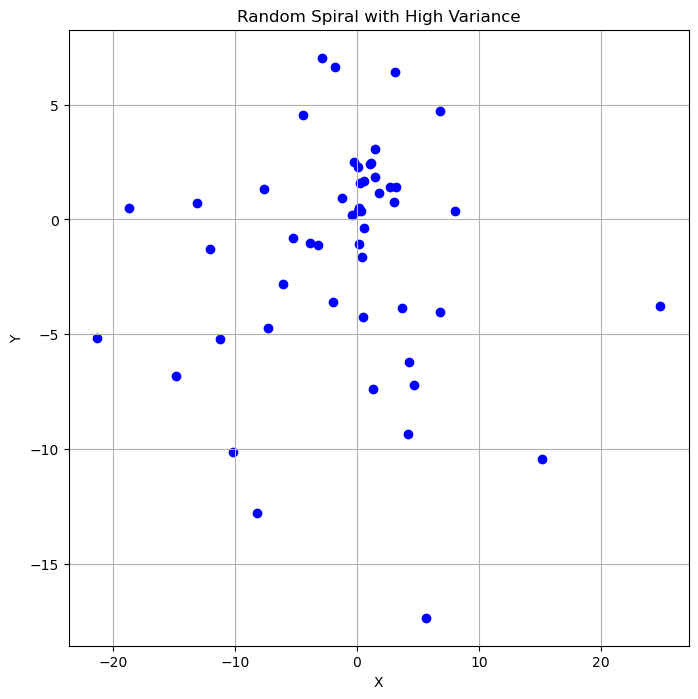

In [123]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_spiral_points(num_points, radius_variance=1.0, angle_variance=1.0):
    points = []
    for _ in range(num_points):
        radius = np.random.normal(0, radius_variance)
        angle = np.random.normal(0, angle_variance)
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append((x, y))
    return points

num_points = 51
radius_variance = 10.0  # Adjust variance as needed
angle_variance = 1.0  # Adjust variance as needed

spiral_points = generate_random_spiral_points(num_points, radius_variance, angle_variance)

# Plot the spiral
spiral_x, spiral_y = zip(*spiral_points)
plt.figure(figsize=(8, 8))
plt.scatter(spiral_x, spiral_y, color='blue')
plt.title('Random Spiral with High Variance')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


In [57]:
example = pd.read_csv('./result/online-retail-clean.csv')
example['TotalSales'] = example['UnitPrice'] * example['Quantity']
example.head()

,main_idx,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [55]:
group_product = example.groupby('Description').agg({'TotalSales': 'sum'}).reset_index()
group_product[group_product['Description'] == 'REGENCY CAKESTAND 3 TIER'] 

,Description,TotalSales
2767,REGENCY CAKESTAND 3 TIER,142592.95


In [60]:
group_product_freq = example.groupby('Description').agg({'InvoiceNo': pd.Series.nunique}).reset_index()
group_product_freq[group_product_freq['Description'] == 'REGENCY CAKESTAND 3 TIER']

,Description,InvoiceNo
2767,REGENCY CAKESTAND 3 TIER,1703


In [61]:
group_product_freq['InvoiceNo'].describe()

count    3877.000000
mean      100.009801
std       154.459459
min         1.000000
25%        10.000000
50%        43.000000
75%       125.000000
max      1971.000000
Name: InvoiceNo, dtype: float64